In [2]:
import os
from typing import List

import matplotlib.pyplot as plt
from matplotlib.container import BarContainer
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import numpy as np

from deepjanus.folder_storage import FolderStorage
from deepjanus.folders import folders

In [3]:
# List of names of individuals
individuals = []
# Lists of results for evaluation of neighborhood of member outside the frontier, for each individual
nbh_eval_results_out = {
    "out": [],
    "in": [],
    "perc": []
}
# Lists of results for evaluation of neighborhood of member inside the frontier, for each individual
nbh_eval_results_in = {
    "out": [],
    "in": [],
    "perc": []
}
# Count of results for re-evaluation of the two members for all individuals
reeval_results = {
    "same": 0,
    "switched": 0,
    "both_inside": 0,
    "both_outside": 0
}

# Obtain a list of serialized results of neighborhood exploration in ascending order of individual index
nbh_storage = FolderStorage(folders.experiments.joinpath('HQ_1', 'neighbors'), 'ind{}.json')
paths = nbh_storage.all_files()
paths.sort(key=lambda p : int(os.path.basename(p).replace("ind", "").replace(".json", "")))

for path in paths:
    # Load experimental data for a neighborhood exploration
    nbh = nbh_storage.load_json_by_path(path)
    
    individuals.append(nbh['original_individual']['name'])
    nbh_size = nbh['neighborhood_size']
    reeval_results[nbh['reevaluation_results']] += 1
    
    # Calculate number of neighbors inside and outside frontier
    out_outside_perc = nbh['neighbors_OUT_outside_frontier_percentage']
    nbh_eval_results_out["perc"].append(out_outside_perc)
    out_outside = round(nbh_size * out_outside_perc)
    out_inside = nbh_size - out_outside
    nbh_eval_results_out["out"].append(out_outside)
    nbh_eval_results_out["in"].append(out_inside)
    
    in_outside_perc = nbh['neighbors_IN_outside_frontier_percentage']
    nbh_eval_results_in["perc"].append(in_outside_perc)
    in_outside = round(nbh_size * in_outside_perc)
    in_inside = nbh_size - in_outside
    nbh_eval_results_in["out"].append(in_outside)
    nbh_eval_results_in["in"].append(in_inside)

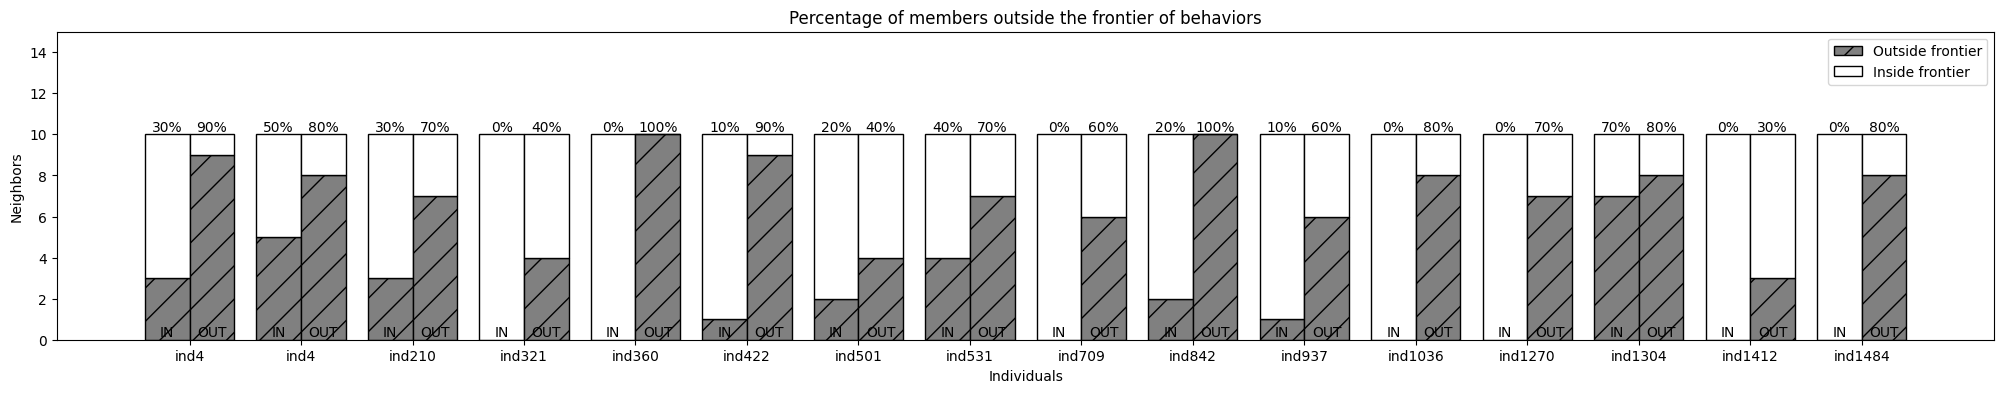

In [4]:
fig: Figure
ax: Axes
fig, ax = plt.subplots(figsize=(25,4))

ind = np.arange(len(individuals))
w = 0.4

def plot_bars(ax: Axes, indexes: List[float], eval_result, mbr: str, width=0.4):
    bar_vcenter = lambda b : b.get_x() + b.get_width() / 2.0
    bar_htop = lambda b : b.get_y() + b.get_height()
    bar_hbottom = lambda b : b.get_y()
    
    # Bottom bar
    bar_container: BarContainer = ax.bar(indexes, eval_result['out'], width, label='Outside frontier', edgecolor='black', color='grey', hatch='/')
    
    # Member name inside bottom bar
    for bar in bar_container:
        ax.text(bar_vcenter(bar), bar_hbottom(bar), mbr, ha='center', va='bottom')
    
    # Top bar
    bar_container: BarContainer = ax.bar(indexes, eval_result['in'], width, label='Inside frontier', bottom=eval_result['out'], edgecolor='black', color='white')
    
    # Percentage number over the bars
    perc_str = list(map(lambda p : f'{int(p * 100)}%', eval_result["perc"]))
    for i in range(len(bar_container)):
        bar = bar_container[i]
        ax.text(bar_vcenter(bar), bar_htop(bar), perc_str[i], ha='center', va='bottom')

# Plot bars representing the results of neighborhood exploration for both members of each individual
plot_bars(ax, ind, nbh_eval_results_in, 'IN', w)
plot_bars(ax, ind + w, nbh_eval_results_out, 'OUT', w)

# Set axis properties
ax.xaxis.set_ticks(ind + w / 2, individuals)
ax.set_ylim(0, 15)
ax.set_title('Percentage of members outside the frontier of behaviors')
ax.set_xlabel('Individuals')
ax.set_ylabel('Neighbors')

# Remove duplicated entries from legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), loc="upper right")

In [5]:
import xlsxwriter

# Write the results to an Excel sheet
workbook = xlsxwriter.Workbook('Neighbors.xlsx')
worksheet = workbook.add_worksheet()

bold = workbook.add_format({'bold': True})
percentage = workbook.add_format({'num_format': '0%'})

worksheet.merge_range('A1:A2', 'Individual', bold)
worksheet.write('B1', 'Member inside frontier', bold)
worksheet.write('B2', 'Neighbors outside frontier', bold)
worksheet.write('C1', 'Member outside frontier', bold)
worksheet.write('C2', 'Neighbors outside frontier', bold)

row = 2
col = 0

for i in range(len(individuals)):
    worksheet.write(row + i, col, individuals[i])
    worksheet.write(row + i, col + 1, nbh_eval_results_in['perc'][i], percentage)
    worksheet.write(row + i, col + 2, nbh_eval_results_out['perc'][i], percentage)

worksheet.autofit()

workbook.close()

Text(0, 0.5, 'Number of individuals')

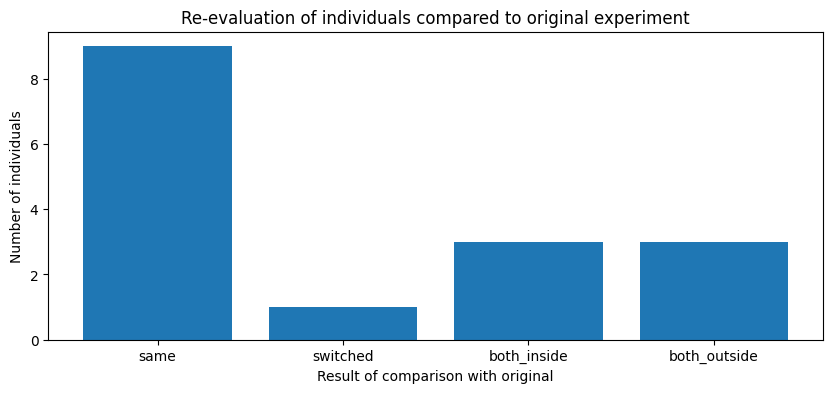

In [7]:
fig: Figure
ax: Axes
fig, ax = plt.subplots(figsize=(10,4))

# Plot the results of the re-evaluation
ax.bar(reeval_results.keys(), reeval_results.values())

# Set axis properties
ax.set_title('Re-evaluation of individuals compared to original experiment')
ax.set_xlabel('Result of comparison with original')
ax.set_ylabel('Number of individuals')